<a href="https://colab.research.google.com/github/bcrompvoets/Star_Formation/blob/main/SF_Classify_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Class I, II, and others using XGBoost

Using data from the four IRAC bands (3.6, 4.5, 5.8, and 8  μm), we classify each object as "other", Class I or Class II protostars. We use a XGBoost Classifier with default values. 

This data comes from Cornu and Montillaud (2021) (https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/647/A116) and includes Spitzer data of the Orion and NGC 2264 star forming regions.

In [26]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# classic ML libraries
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, recall_score, precision_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# custom made libraries
from custom_dataloader import replicate_data

In [5]:

def bootstrap_estimate_and_ci(estimator, X_tr, y_tr, X_va, y_va, scoring_func=None, random_seed=0, 
                               alpha=0.05, n_splits=200):
                        
    scores = []

    if scoring_func == accuracy_score:
        for n in range(0,n_splits):
            estimator.fit(X_tr, y_tr.ravel())  
            scores.append(scoring_func(y_va,estimator.predict(X_va)))
            # scores = list(map(list, zip(*scores)))
        estimate = np.mean(scores)
        lower_bound = np.percentile(scores, 100*(alpha/2))
        upper_bound = np.percentile(scores, 100*(1-alpha/2))
        stderr = np.std(scores)   

    else:
        for n in range(0,n_splits):
            estimator.fit(X_tr, y_tr.ravel())  
            scores.append(scoring_func(y_va,estimator.predict(X_va),average=None))   
            scores = list(map(list, zip(*scores)))
    
        estimate = [np.mean(scores[0]),np.mean(scores[1]),np.mean(scores[2])]
        lower_bound = [np.percentile(scores[0], 100*(alpha/2)),np.percentile(scores[1], 100*(alpha/2)),np.percentile(scores[2], 100*(alpha/2))]
        upper_bound = [np.percentile(scores[0], 100*(1-alpha/2)),np.percentile(scores[1], 100*(1-alpha/2)),np.percentile(scores[2], 100*(1-alpha/2))]
        stderr = [np.std(scores[0]),np.std(scores[1]),np.std(scores[2])]
    
    return estimate, lower_bound, upper_bound, stderr

In [50]:
# data load
X = np.load("Input_Class_AllClasses_Sep.npy")
Y = np.load("Target_Class_AllClasses_Sep.npy") # For original targets via Gutermuth 2009 Method


# custom data loader to pull in custom sized data set
# use seed to get replicable results for now
seed_val = 1111

# the amounts below are how many of each class of object you want in the training set and validation set - leftover amounts given to testing set

# CM21 Split
# amounts_train = [331,1141,231,529,27,70,1257]
amounts_train = [331,331,331,331,27,70,331]
amounts_val = [82, 531, 104, 278, 6, 17, 4359]

# calling custom datagrabber here
inp_tr, tar_tr, inp_va, tar_va, inp_te, tar_te = replicate_data(X, Y, 'seven', amounts_train, amounts_val, seed_val)

# scaling data according to training inputs
scaler_S = StandardScaler().fit(inp_tr)
inp_tr = scaler_S.transform(inp_tr)
inp_va = scaler_S.transform(inp_va)
inp_te = scaler_S.transform(inp_te) # Comment out for 75/25 split

# printouts for double checking all the sets and amounts
print('Sizes of Datasets : Inputs , Targets')
print('------------------------------------')
print(f'Training set: {inp_tr.shape} , {tar_tr.shape} \nValidation set: {inp_va.shape} , {tar_va.shape} \nTesting Set: {inp_te.shape}, {tar_te.shape}')
print('------------------------------------')


Sizes of Datasets : Inputs , Targets
------------------------------------
Training set: (1752, 8) , (1752,) 
Validation set: (5377, 8) , (5377,) 
Testing Set: (19774, 8), (19774,)
------------------------------------


In [53]:
xgb_1 = xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss',gamma=1)

parameters = {'subsample':[0.5,1.0],'max_depth':np.arange(1,11,2),'sampling_method':['uniform']}
xgbcl = GridSearchCV(xgb_1, parameters)


# xgbcl = xgb.XGBClassifier(max_depth=7,sampling_method='uniform',subsample=0.5,use_label_encoder=False,eval_metric='mlogloss')


In [54]:
%%time

xgbcl.fit(inp_tr,tar_tr.ravel())  # fit the model with training set


# Find the predicted values
pred_tr = xgbcl.predict(inp_tr)
pred_va = xgbcl.predict(inp_va)

print(classification_report(tar_va,pred_va))
print(classification_report(tar_tr,pred_tr))

              precision    recall  f1-score   support

           0       0.59      0.88      0.71        82
           1       0.67      0.87      0.76       531
           2       0.86      0.98      0.92       104
           3       0.72      0.95      0.82       278
           4       0.67      0.33      0.44         6
           5       0.36      0.29      0.32        17
           6       0.99      0.93      0.96      4359

    accuracy                           0.92      5377
   macro avg       0.69      0.75      0.70      5377
weighted avg       0.94      0.92      0.92      5377

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       331
           1       0.96      0.98      0.97       331
           2       0.99      0.99      0.99       331
           3       0.99      0.99      0.99       331
           4       0.95      0.78      0.86        27
           5       1.00      0.79      0.88        70
           6       0.98 

In [51]:
f1_tr = []
f1_va = []
G = np.arange(0,15)
for g in G:
    xgbcl = xgb.XGBClassifier(gamma=g,max_depth=7,sampling_method='uniform',subsample=0.5,use_label_encoder=False,eval_metric='mlogloss')
    xgbcl.fit(inp_tr,tar_tr)
    pred_tr = xgbcl.predict(inp_tr)
    pred_va = xgbcl.predict(inp_va)

    f1_tr.append(f1_score(tar_tr,pred_tr,average=None))
    f1_va.append(f1_score(tar_va,pred_va,average=None))
    




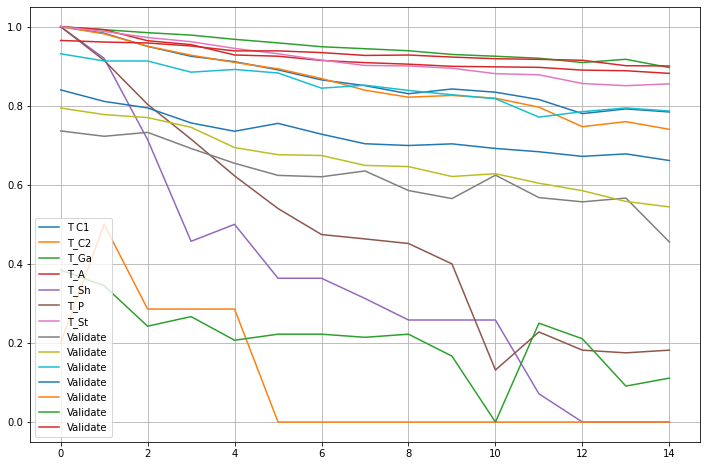

In [52]:
plt.subplots(1,1,figsize=(12,8))
import matplotlib.pylab as pl

n = 7
colors = pl.cm.Reds(np.linspace(0,1,7))

# plt.set_cmap('Blues')
plt.plot(G,f1_tr,label=['T C1','T_C2','T_Ga','T_A','T_Sh','T_P','T_St'])

# plt.set_cmap('Reds')
plt.plot(G,f1_va,label='Validate')


plt.legend()
plt.grid(True)

In [22]:
print(xgbcl.best_params_)
print(xgbcl.best_estimator_)



{'max_depth': 7, 'sampling_method': 'uniform', 'subsample': 1.0}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=10, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1,
              sampling_method='uniform', scale_pos_weight=None, subsample=1.0,
              tree_method='exact', use_label_encoder=False, ...)


## Bootstrapping for Errors

In [23]:
# %%time 

# f = open("PRAScores_XGB_CII500_Gtars.txt", "w")

# est, low, up, stderr = bootstrap_estimate_and_ci(xgbcl, inp_tr, tar_tr.ravel(),  inp_va, tar_va, scoring_func=recall_score, random_seed=0, 
#                               alpha=0.05, n_splits=200)

# f.write("XGB Recall\n")
# f.write("{:.3f}".format(est[0])+" _{"+"{:.3f}".format(low[0])+"}^{"+"{:.3f}".format(up[0])+"} , "+"{:.3f}".format(stderr[0])+"//\n")
# f.write("{:.3f}".format(est[1])+" _{"+"{:.3f}".format(low[1])+"}^{"+"{:.3f}".format(up[1])+"} , "+"{:.3f}".format(stderr[1])+"//\n")
# f.write("{:.3f}".format(est[2])+" _{"+"{:.3f}".format(low[2])+"}^{"+"{:.3f}".format(up[2])+"} , "+"{:.3f}".format(stderr[2])+"//\n")
# f.write("\n")

# est, low, up, stderr = bootstrap_estimate_and_ci(xgbcl, inp_tr, tar_tr.ravel(), inp_va, tar_va.ravel(), scoring_func=precision_score, random_seed=0, 
#                               alpha=0.05, n_splits=200)
                            
# f.write("XGB Precision\n")
# f.write("{:.3f}".format(est[0])+" _{"+"{:.3f}".format(low[0])+"}^{"+"{:.3f}".format(up[0])+"} , "+"{:.3f}".format(stderr[0])+"//\n")
# f.write("{:.3f}".format(est[1])+" _{"+"{:.3f}".format(low[1])+"}^{"+"{:.3f}".format(up[1])+"} , "+"{:.3f}".format(stderr[1])+"//\n")
# f.write("{:.3f}".format(est[2])+" _{"+"{:.3f}".format(low[2])+"}^{"+"{:.3f}".format(up[2])+"} , "+"{:.3f}".format(stderr[2])+"//\n")
# f.write("\n")

# est, low, up, stderr = bootstrap_estimate_and_ci(xgbcl, inp_tr, tar_tr.ravel(), inp_va, tar_va.ravel(), scoring_func=accuracy_score, random_seed=0, 
#                                alpha=0.05, n_splits=200)
                            
# f.write("XGB Accuracy\n")
# f.write("{:.3f}".format(est)+" _{"+"{:.3f}".format(low)+"}^{"+"{:.3f}".format(up)+"} , "+"{:.3f}".format(stderr)+"//\n")
# f.write("\n")
# f.close()

CPU times: user 23min 42s, sys: 12.3 s, total: 23min 55s
Wall time: 3min 1s
